# Chapter 10 semilinear SPDEs

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
import scipy
from scipy import sparse
from scipy.sparse import linalg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
import Utils
import time
fft=np.fft.fft
fft2=np.fft.fft2
ifft=np.fft.ifft
ifft2=np.fft.ifft2

In [57]:
def icspde_dst1(u):
    return scipy.fftpack.dst(u,type=1,axis=0)/2

def get_onedD_bj(dtref, J, a, r):
    eps=0.001
    return np.sqrt(2 * dtref * np.arange(1,J) ** (-(2 * r + 1 + eps)) / a)
#
def get_onedD_dW(bj, kappa, iFspace, M):
    if (kappa == 1):
        nn = np.random.randn(M, bj.size)
    else:
        nn = np.sum(np.random.randn(kappa, M, bj.size), axis=0)
    X = bj * nn
    if iFspace == 1:
        dW=X
    else:
        dW = icspde_dst1(np.squeeze(X))
        dW = dW.reshape(X.shape)
    return dW

dtref=0.01; kappa=100; r=1/2; J=128; a=1
bj = get_onedD_bj(dtref, J, a, r)
dW = get_onedD_dW(bj, kappa, 0, 1)

d:\Research\SPDE\Code\learnSDE\Utils.py:247: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


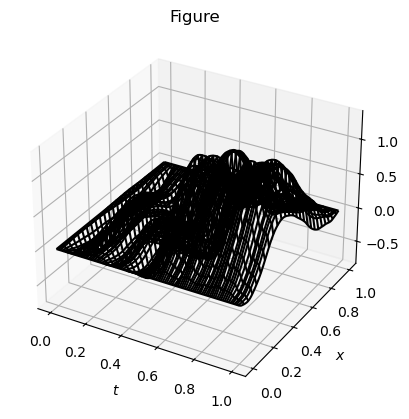

In [58]:
dtref=0.01; kappa=100; r=2; J=128; a=1
bj = get_onedD_bj(dtref, J, a, r)
WW=np.zeros((J+1,101)); t=np.linspace(0, 1, 101)
for k in range(100):
  dW = get_onedD_dW(bj, 1, 0, 1)
  WW[1:-1, k+1] = WW[1:-1, k] + dW
[T,X]=np.meshgrid(t,np.linspace(0,a,J+1))
Utils.Plot_wireframe(T,X,WW,rstride=5,cstride=1,colors='k')
# Utils.Plot_contourf(T, X, WW)


In [59]:
def Get_oned_bj(dtref, J, a, r):
    j = np.hstack([np.arange(1, J//2 + 1), np.arange(-J//2+1, 0)])
    eps = 0.001
    qj = np.hstack([[0], np.abs(j)**(-(2*r + 1 + eps)/2)])
    bj = np.sqrt(qj * dtref / a) * J
    return bj

def Get_oned_dW(bj, kappa, iFspace, M):
    J = bj.size
    if kappa == 1:
        nn = np.random.randn(M, J)
    else:
        nn = np.sum(np.random.randn(kappa, M, J), 0)
    nn = np.vstack([nn[0:1,:],
                   (nn[1:J//2,:] + 1j * nn[J//2 + 1:J,:]) / sqrt(2),
                   nn[J//2:J//2+1,:],
                   (nn[J//2-1:0:-1,:] - 1j * nn[J-1:J // 2 :-1,:])/ sqrt(2)])
    X = bj * nn
    if iFspace == 1:
        dW = X
    else:
        dW = np.real(ifft(X))
    return dW



In [60]:
def Get_twod_bj(dtref, J, a, alpha):
    lambdax = 2 * pi * np.hstack([np.arange(0,J[0]//2 +1), np.arange(- J[0]//2 + 1,0)]) / a[0]
    lambday = 2 * pi * np.hstack([np.arange(0,J[1]//2 +1), np.arange(- J[1]//2 + 1,0)]) / a[1]
    lambdaxx, lambdayy = np.meshgrid(lambdax, lambday, indexing='ij')
    sqrt_qj = np.exp(- alpha * (lambdaxx ** 2 + lambdayy ** 2))
    bj = sqrt_qj * sqrt(dtref) * J[0] * J[1] / sqrt(a[0] * a[1])
    return bj

def Get_twod_dW(bj, kappa, M):
    J=bj.shape
    if (kappa == 1):
        nn=np.random.randn(M,J[0],J[1],2)
    else:
        nn=np.sum(np.random.randn(kappa,M,J[0],J[1],2),0)
    nn2=np.dot(nn, np.array([1,1j]))
    tmp=ifft2(bj*nn2)
    dW1=np.real(tmp)
    dW2=np.imag(tmp)
    return dW1, dW2

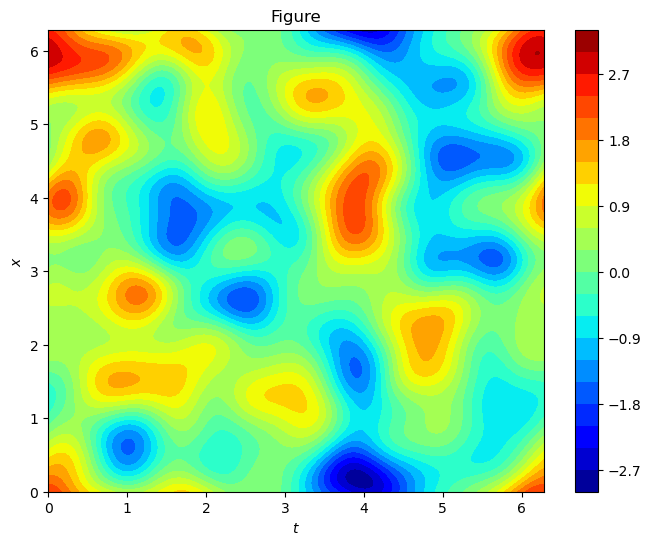

In [61]:
J=[512, 512]; dtref=0.01; kappa=100; a=[2*pi, 2*pi]
alpha=0.05; 
bj = Get_twod_bj(dtref, J, a, alpha)
W1, W2 = Get_twod_dW(bj, kappa, 1)
gridx = np.linspace(0, a[0], J[0])
gridy = np.linspace(0, a[1], J[1])
Utils.Plot_contourf(gridx, gridy, W1[0, :, :])
# print(W1.shape, W2.shape)

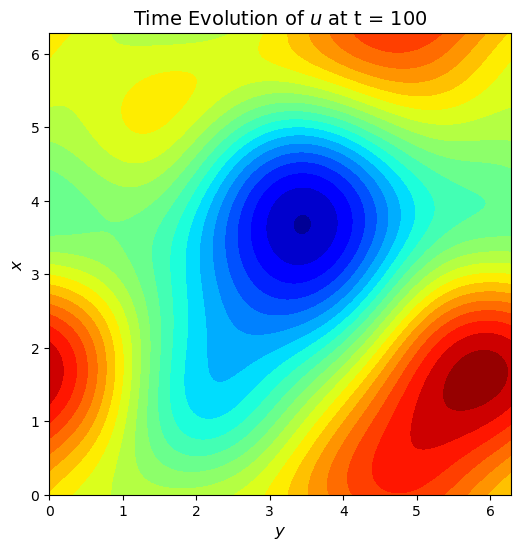

In [ ]:
W = np.zeros((J[0], J[1], 101))
t = np.linspace(0, 1, 101)
alpha = 0.5
bj = Get_twod_bj(dtref, J, a, alpha)
for k in range(0, 99, 2):
    W1, W2 = Get_twod_dW(bj, 1, 1)
    W[:, :, k + 1] = W[:, :, k] + W1[0, :, :]
    W[:, :, k + 2] = W[:, :, k + 1] + W2[0, :, :]

gridx = np.linspace(0, a[0], J[0])
gridy = np.linspace(0, a[1], J[1])
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(gridy, gridx, W[:, :, 0], 20, cmap='jet')
ax.set_xlabel(r'$y$', fontsize=12)
ax.set_ylabel(r'$x$', fontsize=12)
ax.set_title('Time Evolution of $u$ at t = 0', fontsize=14)
ax.set_aspect('equal')

def update(frame):
    ax.clear() 
    contour = ax.contourf(gridy, gridx, W[:, :, frame], 20, cmap='jet')
    ax.set_xlabel(r'$y$', fontsize=12)
    ax.set_ylabel(r'$x$', fontsize=12)
    ax.set_title(f'Time Evolution of $u$ at t = {frame}', fontsize=14)
    ax.set_aspect('equal')
    return contour

ani = FuncAnimation(fig, update, frames= 101, interval=100*dtref, blit=False)
ani.save('evolution.gif', writer=PillowWriter(fps=10))
plt.show()

Here We use the semi-implicit Eulwe maruyama Method plus FDM.

In [62]:
import scipy.sparse
import scipy.sparse.linalg


def Spde_EM_FDM_Exponential(u0, T, a, N, J, epsilon, sigma, ell, fhandle):
    dt = T / N
    t = np.linspace(0, T, N + 1)
    x = np.linspace(0, a, J + 1)
    h = a / J
    A = scipy.sparse.diags([-1, 2, -1], [-1, 0, 1], shape=(J + 1, J + 1), format='csc')
    ind = np.arange(0, J + 1)
    A[0, 1] = -2
    A[-1, -2] = -2
    EE = scipy.sparse.identity(ind.size, format='csc') + (dt * epsilon/h**2) * A
    ut = np.zeros((J + 1, t.size))
    ut[:, 0] = u0
    un = u0
    EEinv = scipy.sparse.linalg.factorized(EE)
    flag = False
    for n in range(N):
        fu = fhandle(un)
        if flag == False:
            dW1, dW2 = Utils.Circlulant_Exponential(x, ell)
            flag = True
        else:
            dW1 = dW2
            flag=False
        un = EEinv(un + dt * fu + sigma * sqrt(dt) * dW1)
        ut[:, n + 1] = un
    return t, x, ut

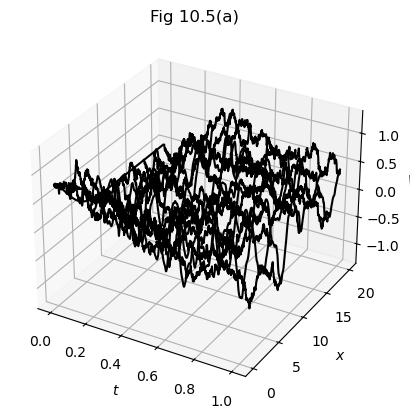

In [63]:
from numba import vectorize, float64
@vectorize([float64(float64)])
def fNagumo(u):
    return u*(1-u)*(u+0.5)

a=20; J = int(1e3)
x = np.linspace(0, a, J + 1)
u0 = 1/(1+np.exp(-(2-x)/sqrt(2)))
ell = 1; 
N = int(1e3); 
T = 1; epsilon = 1; sigma = 1
t, x, ut = Spde_EM_FDM_Exponential(u0, T, a, N, J, epsilon, sigma, ell, fNagumo)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
[T,X]=np.meshgrid(t, x)
CS=ax.plot_wireframe(T,X,ut,rstride=100,cstride=100,colors='k')
s=ax.set_xlabel(r'$t$')
s=ax.set_ylabel(r'$x$')
s=ax.set_zlabel(r'$W$')
s=ax.set_title(r'Fig 10.5(a)') 
#
# fig, ax = plt.subplots(figsize=(8, 6))
# [T, X] = np.meshgrid(t, x)
# pic = ax.contourf(T, X, ut, levels=20, cmap='jet')
# plt.colorbar(pic, ax=ax)
# ax.set_xlabel(r'$t$')
# ax.set_ylabel(r'$x$')
# ax.set_title(r'Nagumo') 
# plt.show()


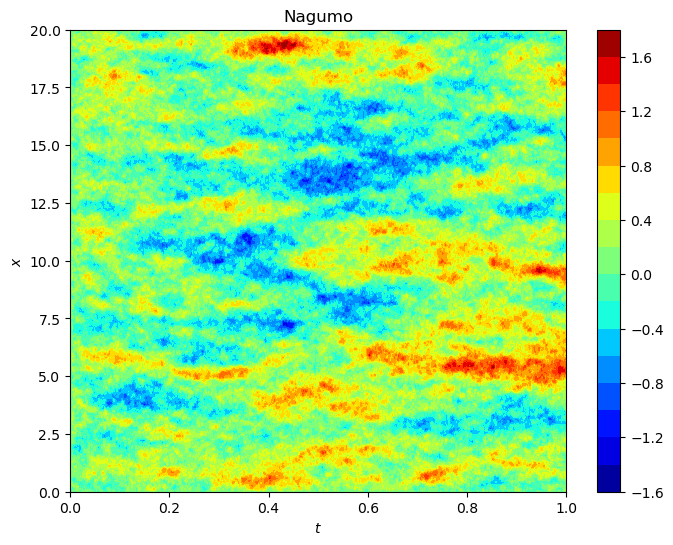

In [64]:
def Spde_EM_FDM_white(u0, T, a, N, J, epsilon, sigma, fhandle):
    dt = T / N
    h = a / J
    t = np.linspace(0, T, N + 1)
    x = np.linspace(0, a, J + 1)
    ind = np.arange(1, J)
    A = scipy.sparse.diags([-1, 2, -1], [-1, 0, 1], shape=(J + 1, J + 1), format='csc')
    A = A[:, ind]; A = A[ind, :]
    EE = scipy.sparse.identity(ind.size, format='csc') + (dt * epsilon / h**2) * A
    ut = np.zeros((J + 1, t.size))
    ut[:, 0] = u0
    un = u0[ind]
    EEinv = scipy.sparse.linalg.factorized(EE)
    for n in range(N):
        fu = fhandle(un)
        Wn = sqrt(dt/h) * np.random.randn(J - 1)
        un = EEinv(un + dt * fu + sigma * Wn)
        ut[ind, n + 1] = un
    return t,x, ut

a=20; J = int(1e3)
x = np.linspace(0, a, J + 1)
u0 = np.zeros(J + 1)
N = int(1e3); 
T = 1; epsilon = 1; sigma = 1
t, x, ut = Spde_EM_FDM_white(u0, T, a, N, J, epsilon, sigma,fNagumo)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# [T,X]=np.meshgrid(t, x)
# CS=ax.plot_wireframe(T,X,ut,rstride=100,cstride=100,colors='k')
# s=ax.set_xlabel(r'$t$')
# s=ax.set_ylabel(r'$x$')
# s=ax.set_zlabel(r'$W$')
# s=ax.set_title(r'Fig 10.5(a)') 

fig, ax = plt.subplots(figsize=(8, 6))
[T, X] = np.meshgrid(t, x)
pic = ax.contourf(T, X, ut, levels=20, cmap='jet')
plt.colorbar(pic, ax=ax)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$x$')
ax.set_title(r'Nagumo') 
plt.show()

C:\Users\14153\AppData\Local\Temp\ipykernel_29344\723377608.py:46: UserWarning: The following kwargs were not used by contour: 'labels'
  pic = ax.contourf(T, X, ureft, labels=20, cmap='jet')


Text(0.5, 1.0, 'Fig 10.9(b)')

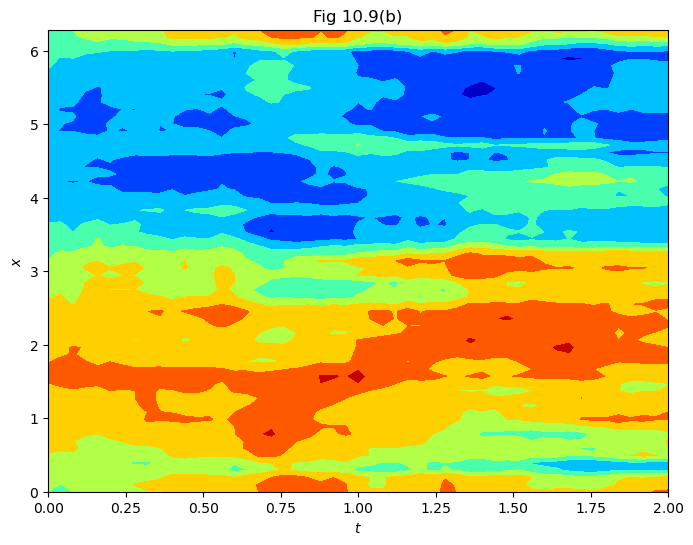

In [65]:
import numpy.matlib


def Spde_oned_Galerkin(u0, T, a, N, kappa, Jref, J, epsilon, fhandle, ghandle, r, M):
    dtref = T / N
    dt = kappa * dtref
    t = np.linspace(0, T, N + 1)
    IJJ=np.arange(J // 2 + 1,Jref - J // 2, dtype='int' )
    # set linear operator
    kk=(2 * pi/ a) * np.hstack([np.arange(0, Jref // 2 + 1),
                                np.arange(- Jref // 2 + 1, 0)]) 
    Dx=1j * kk
    MM=np.real(- epsilon * Dx ** 2)
    EE=1 / (1 + dt * MM);    EE[IJJ]=0;    #EE=EE.reshape((1,EE.size));
    # initiliase noise
    iFspace=1
    bj=Get_oned_bj(dtref,Jref,a,r);    bj[IJJ]=0
    # set initial conditon
    ut=np.zeros((Jref+1,N//kappa+1))
    ut[:,0]=u0;     u=u0[0:Jref];    uh0=np.copy(fft(u))
    uh=np.matlib.repmat(uh0,M,1);    u=(ifft(uh))
    #
    for n in range(N // kappa):
        uh[:,IJJ]=0
        fhu=fft(fhandle(np.real(u)));                fhu[:,IJJ]=0
        dW=Get_oned_dW(bj,kappa,iFspace,M);        dW[:,IJJ]=0
        gdWh=fft(ghandle(u)*np.real(ifft(dW)));     gdWh[:,IJJ]=0
        uh_new=EE*(uh + dt * fhu + gdWh);   uh=uh_new
        u=np.real(np.copy((ifft(uh))))
        ut[0:Jref,n + 1]=u[-1,:]
    ut[Jref,:]=ut[0,:]
    u=np.vstack([u,u[:]])
    return t, x, u, ut

@vectorize([float64(float64)])
def fAC(u):
    return u-u**3

T=2; N=50; a=2*pi; J=64; 
r=1; epsilon=0.001; sigma=1
M=2; kappa=1
x=np.linspace(0,a,J+1); u0=np.sin(x)
tref, xref, uref, ureft = Spde_oned_Galerkin(u0,T,a,N,kappa,J,J,epsilon, fAC, lambda u: sigma, r, M)    
[T, X]=np.meshgrid(tref,x)
fig, ax = plt.subplots(figsize=(8, 6))
pic = ax.contourf(T, X, ureft, labels=20, cmap='jet')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$x$')
ax.set_title(r'Fig 10.9(b)')


2D

In [66]:
def spde_twod_Gal(u0,T,a,N,kappa,J,epsilon,fhandle,ghandle,alpha,M):
    """
    Alg 10.11 Page 471
    """
    dtref=T / N;    Dt=kappa * dtref;    t=np.linspace(0,T,N+1)
    #
    lambdax=(2*pi/a[0]) * np.hstack([np.arange(0,J[0]//2+1), np.arange(-J[0]//2+1,0)])
    lambday=(2*pi/a[1]) * np.hstack([np.arange(0,J[1]//2+1), np.arange(-J[1]//2+1,0)])
    lambdaxx,lambdayy=np.meshgrid(lambdax,lambday,indexing='ij')
    Dx=(1j * lambdaxx);    Dy=(1j * lambdayy)
    A=- (Dx ** 2 + Dy ** 2);    MM=np.real(epsilon * A)
    EE=1 / (1 + Dt * MM)
    # initialise noise
    bj=Get_twod_bj(dtref,J,a,alpha)
    # initial conditions
    u=np.matlib.tile(u0[:-1,:-1],(M,1,1))
    uh=np.matlib.tile(fft2(u0[:-1,0:-1]),(M,1,1))
    ut=np.zeros((J[0] + 1,J[1] + 1,N//kappa+1))
    ut[:,:,0]=u0
    for n in range(N // kappa):
        fh=fft2(fhandle(u))
        dW,dW2=Get_twod_dW(bj,kappa,M)
        gudWh=fft2(ghandle(u)*dW)
        uh_new=EE*(uh + Dt * fh + gudWh)
        u=np.real(ifft2(uh_new))
        ut[:-1,:-1,n + 1]=u[-1,:,:]
        uh=uh_new
    u[:,-1,:] =u[:,0,:];    u[:,:,-1] =u[:,:,0]
    ut[:,-1,:]=ut[:,0,:];   ut[-1,:,:]=ut[0,:,:]
    return t,u,ut
#
T=10; N=int(1e3); a=np.array([2*pi,16]); J=np.array([128,64])
alpha=0.1; epsilon=1e-3; sigma=0.1; M=2; kappa=1;
x=np.linspace(0,a[0],J[0]+1); y=np.linspace(0,a[1],J[1]+1)
xx,yy=np.meshgrid(x,y,indexing='ij')
# initial data printed in book
# u0=np.sin(xx)*np.cos(pi*yy/8)
# initial data as he intended (x and y switched)
# u0=np.sin(yy)*np.cos(pi*xx/8);
# initial data that gives figure in book
u0=np.sin(xx*8/pi)*np.cos(pi**2*yy/64);
t,u,ut=spde_twod_Gal(u0,T,a,N,kappa,J,epsilon, fAC, lambda u: sigma, alpha,M)


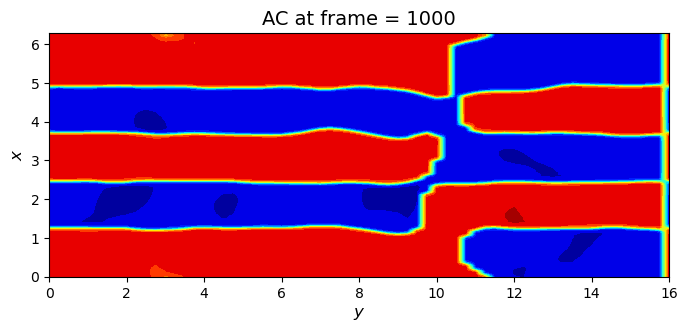

In [39]:
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(yy, xx, ut[:, :, 0], 20, cmap='jet')
ax.set_xlabel(r'$y$', fontsize=12)
ax.set_ylabel(r'$x$', fontsize=12)
ax.set_title('AC at frame = 0', fontsize=14)
ax.set_aspect('equal')

def update(frame):
    ax.clear() 
    contour = ax.contourf(yy, xx, ut[:, :, frame], 20, cmap='jet')
    ax.set_xlabel(r'$y$', fontsize=12)
    ax.set_ylabel(r'$x$', fontsize=12)
    ax.set_title(f'AC at frame = {frame}', fontsize=14)
    ax.set_aspect('equal')
    return contour

ani = FuncAnimation(fig, update, frames= 1001, interval=1000*T / N, blit=False)
ani.save('evolution.gif', writer=PillowWriter(fps=10))
plt.show()

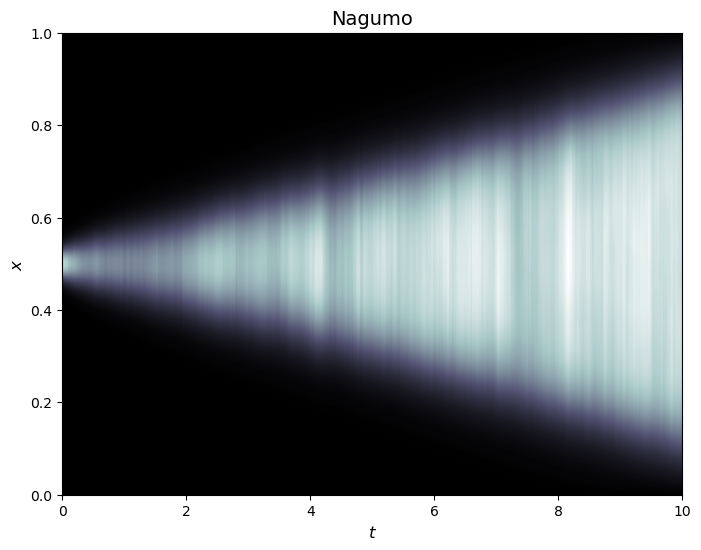

In [68]:
def Spde_EM_FEM(u0, T, a, Nref, kappa, neref, L, epsilon, fhandle, ghandle, r, M):
    ne = neref // L
    h = a / ne
    nvtx = ne + 1
    dtref = T / Nref
    dt = kappa * dtref
    t = np.linspace(0, T, Nref//kappa + 1)
    p = epsilon * np.ones(ne)
    q = np.ones(ne)
    f = np.ones(ne)
    uh, A, b, KK, MM = Utils.FEM_Solver1D_r1(ne, p, q, f)
    EE = MM + dt * KK
    ZM = np.zeros((M, 1))
    bj = get_onedD_bj(dtref, neref, a, r)
    bj[ne:-1] = 0
    iFspace = 0
    u = np.matlib.repmat(u0, M, 1)
    ut = np.zeros((nvtx, Nref//kappa + 1))
    ut[:, 0] = u[0, :]
    b = np.zeros(ne - 1)
    gdw = np.copy(b)
    EEinv = scipy.sparse.linalg.factorized(EE)
    for k in range(Nref//kappa):
        dWJ = get_onedD_dW(bj, kappa, iFspace, M)
        dWL = np.hstack([ZM, dWJ, ZM])
        dWL = dWL[:, ::L]
        gdW = ghandle(u) * dWL
        fu = fhandle(u)
        for m in range(M):
            b = Utils.oned_linear_FEM_b(ne, h, fu[m,:])
            gdw = Utils.oned_linear_FEM_b(ne, h, gdW[m, :])
            u1 = EEinv(MM.dot(u[m, 1:-1]) + dt * b + gdw)
            u[m, :] = np.hstack([0, u1, 0])
        ut[:, k + 1] = u[-1, :]
    return t, u, ut

T=10; N=int(1e3); a=1; ne=512; h=a/ne;
epsilon=1e-3; r=1; M=1; sigma=0.1;
x=np.linspace(0,a,ne+1); u0=np.exp(-(x-0.5)**2/epsilon)
s0=np.random.RandomState()
t,u,ut = Spde_EM_FEM(u0,T,a,N,1,ne,1,epsilon, fNagumo, lambda u:sigma*u, r,M)

fig, ax = plt.subplots(figsize=(8, 6))
[T, X]=np.meshgrid(t,x)
pic = ax.contourf(T, X, ut, levels=200, cmap=plt.cm.bone)
ax.set_xlabel(r'$t$', fontsize=12)
ax.set_ylabel(r'$x$', fontsize=12)
ax.set_title(f'Nagumo', fontsize=14)
# ax.set_aspect('equal')
plt.show()